# Tensors

Attention, si vous ne maitrisez pas déjà numpy, vous devez faire le TP spécifique numpy (dossier `py`).  

In [1]:
%reset -f

In [2]:
import numpy as np
import tensorflow as tf
import torch

import matplotlib.pyplot as plt
import os
np.set_printoptions(linewidth=500,precision=2,suppress=True)

2024-11-28 16:07:06.009867: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Tenseurs

### Definition

Un tenseur est un tableau multidimensionnel. Ils ont un type de données `dtype` et une forme `shape`. Nous allons comparer 3 lib. À la fin, vous devrez pouvoir comprendre le tableau ci-dessous


|  | numpy | tensorflow | pytorch |
|:---|:--- |:---|:---|
| défaut  | 64 bits | 32 bits | 32float/64int bits |
| défaut  | CPU | GPU | CPU
| GPU possible | non | oui | oui |
| tenseurs mutables  | oui | non | oui|
| cast automatique | oui | non |oui |
| opération inplace | certaines | aucune | au choix |
| différentiation | non | oui | oui |

Attention: numpy ne peut pas servir pour créer des réseaux de neurone, mais elle est bien pratique pour prétraiter les données.

In [3]:
data = [[1., 2],[3, 4],[5,6]]
X_torch = torch.tensor(data)
X_tf = tf.constant(data)
X_np = np.array(data)

In [4]:
for X in [X_torch,X_tf,X_np]:
    print(X.shape,X.dtype)

torch.Size([3, 2]) torch.float32
(3, 2) <dtype: 'float32'>
(3, 2) float64


***À vous:*** Qu'est-ce que cela donne avec `data = [[1, 2],[3, 4],[5,6]]` (le point en moins)?
  

***À vous:*** Que vérifie-t-on dans le programme ci-dessous?

In [5]:
def modify(X):
    X[0,0]=7

In [6]:
for title,X in [("torch",X_torch),("tf",X_tf),("np",X_np)]:
    print(title)
    try:
        modify(X)
        print(X)
    except Exception as e:
        print(e)

torch
tensor([[7., 2.],
        [3., 4.],
        [5., 6.]])
tf
'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment
np
[[7. 2.]
 [3. 4.]
 [5. 6.]]


### Conversions

On peut appliquer des fonctions d'une lib sur des tenseurs d'autre lib, mais le résultat est imprévisible.

In [7]:
for title_tensor,X in [("torch",X_torch),("tf",X_tf),("np",X_np)]:
    print("title_tensor:",title_tensor)
    for title_func,fn in [("torch",torch.sin),("tf",tf.sin),("np",np.sin)]:
        print("\t title_func:",title_func)
        try:
            res=fn(X)
            print("\t\t",X.dtype)
        except Exception as e:
            print("\t\t",e)

title_tensor: torch
	 title_func: torch
		 torch.float32
	 title_func: tf
		 torch.float32
	 title_func: np
		 torch.float32
title_tensor: tf
	 title_func: torch
		 sin(): argument 'input' (position 1) must be Tensor, not tensorflow.python.framework.ops.EagerTensor
	 title_func: tf
		 <dtype: 'float32'>
	 title_func: np
		 <dtype: 'float32'>
title_tensor: np
	 title_func: torch
		 sin(): argument 'input' (position 1) must be Tensor, not numpy.ndarray
	 title_func: tf
		 float64
	 title_func: np
		 float64


Idem si on fait des opérations entre tenseurs.

In [8]:
for title_tensor1,X in [("torch",X_torch),("tf",X_tf),("np",X_np)]:
    print("title_tensor1:",title_tensor1)
    for title_tensor2,Y in [("torch",X_torch),("tf",X_tf),("np",X_np)]:
        print("\t title_tensor2:",title_tensor2)
        try:
            Z=X+Y
            print("\t\t",Z.dtype)
        except Exception as e:
            print("\t\t",e)

title_tensor1: torch
	 title_tensor2: torch
		 torch.float32
	 title_tensor2: tf
		 <dtype: 'float32'>
	 title_tensor2: np
		 torch.float64
title_tensor1: tf
	 title_tensor2: torch
		 <dtype: 'float32'>
	 title_tensor2: tf
		 <dtype: 'float32'>
	 title_tensor2: np
		 <dtype: 'float32'>
title_tensor1: np
	 title_tensor2: torch
		 Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.
	 title_tensor2: tf
		 <dtype: 'float32'>
	 title_tensor2: np
		 float64


Certaine lib font des 'cast' automatique, d'autre nom:

In [9]:
np.zeros([3,3],dtype=np.float32)+np.zeros([3,3],dtype=np.float64)+np.zeros([3,3],dtype=np.int32)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [10]:
try:
    tf.zeros([3,3],dtype=tf.float32)+tf.zeros([3,3],dtype=np.float64)
except Exception as e:
    print(e)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2] name: 


In [11]:
torch.zeros([3,3],dtype=torch.float32)+torch.zeros([3,3],dtype=torch.float64)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)

### Méthode post/prétraitement numpy

***Règle d'or:*** Séparer bien votre programme en plusieurs parties. Chaque partie avec sa lib ad hoc. Faites des conversions explicite entre ces parties. Exemple:

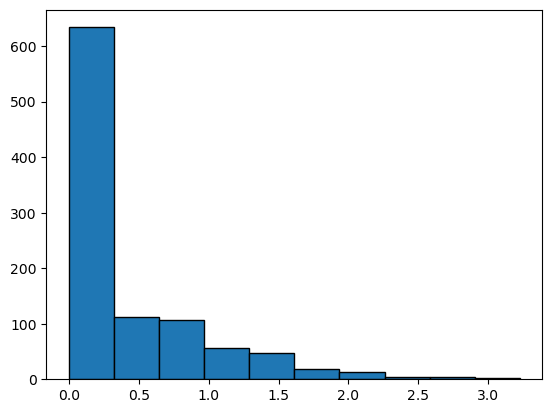

In [12]:
#Création, prétraitement des données. Numpy est le plus pratique:
X_np=np.random.normal(size=[1000])
X_np[X_np<0]=0
plt.hist(X_np,edgecolor='k');

In [13]:
#Traitement tensorflow:
X_tf=tf.constant(X_np,dtype=tf.float32)
X_tf=tf.sin(X_tf**3) #imaginer plein de gros calculs

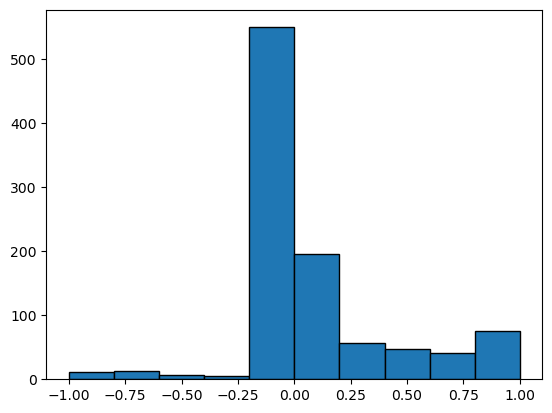

In [14]:
#post traitement
plt.hist(X_tf.numpy(),edgecolor="k");

### Méthode quasi tout torch

Torch est très proche de numpy dans ses possibilités (en particulier le fait de pouvoir modifier des bouts de tenseurs).

Perso, dans un projet de deeplearning, j'utilise quasi tout le temps torch, y compris pour les prétraitements.

Et dans un projet sans deeplearning, j'utilise uniquement numpy qui est un peu plus rapide si on travaille uniquement sur cpu.

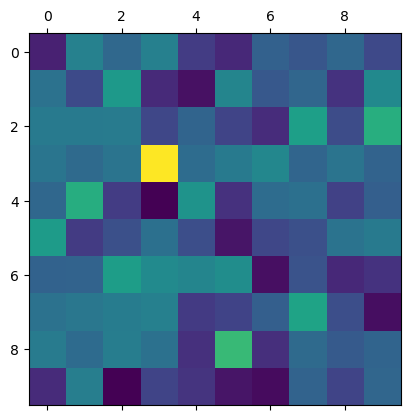

In [15]:
torch.set_default_dtype(torch.float64)
A=torch.ones([10,10])
A[3,3]=5
A+=torch.randn(10,10)

plt.matshow(A);

On verra plus tard qu'il faut parfois faire ceci:

Si on bosse sur le GPU:

    plt.matshow(A.cpu())

Si on `A` est relié à un graph de calcul

    plt.matshow(A.detach())

Et si les deux

    plt.matshow(A.detach().cpu()



## Accélération GPU

En tf ou en torch, on peut accélérer les calculs avec le GPU.


### Tensorflow


Si dans colab, vous n'avez mis en route le GPU, la liste ci-dessous sera vide. Sinon, allez dans

    Exécution>modifier le type d'excécution

Colab vous propose alors 1 GPU. D'autre serveur peuvent en proposer plus.  

In [16]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]

Quand on a créé un tenseur, l'attribut `.device` fournit une chaine de caractère qui caractérise le dispositif l'héberge.

In [17]:
X_tf=tf.ones([3,3])
X_tf.device

'/job:localhost/replica:0/task:0/device:CPU:0'

Cette chaîne de caractère se termine par `cuda:N` ou `GPU:N` signifie que le tenseur est placé sur le `N`-ème GPU de l'hôte.


In [18]:
size=7000
X_tf=tf.ones([size,size])

2024-11-28 16:07:10.147566: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 196000000 exceeds 10% of free system memory.


In [19]:
%%time
X_tf@X_tf

2024-11-28 16:07:10.208540: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 196000000 exceeds 10% of free system memory.


CPU times: user 21.1 s, sys: 426 ms, total: 21.5 s
Wall time: 2.22 s


<tf.Tensor: shape=(7000, 7000), dtype=float32, numpy=
array([[7000., 7000., 7000., ..., 7000., 7000., 7000.],
       [7000., 7000., 7000., ..., 7000., 7000., 7000.],
       [7000., 7000., 7000., ..., 7000., 7000., 7000.],
       ...,
       [7000., 7000., 7000., ..., 7000., 7000., 7000.],
       [7000., 7000., 7000., ..., 7000., 7000., 7000.],
       [7000., 7000., 7000., ..., 7000., 7000., 7000.]], dtype=float32)>

### Placement explicite

Mais on peut décider soit même du placement en utilisant le contexte-manager `tf.device`:

In [20]:
%%time
with tf.device("CPU:0"): #ou "GPU:i" pour utiliser le GPU numéro i
    print( (X_tf@X_tf).shape)

2024-11-28 16:07:12.434033: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 196000000 exceeds 10% of free system memory.


(7000, 7000)
CPU times: user 21.2 s, sys: 450 ms, total: 21.7 s
Wall time: 2.25 s


### Torch

In [21]:
X_torch=torch.ones([size,size])
X_torch.device

device(type='cpu')

In [22]:
X_torch=X_torch.to("cuda")
X_torch.device

AssertionError: Torch not compiled with CUDA enabled

On pourrait revenir en arrière avec:

    X_torch=X_torch.to("cpu")

ou bien

    X_torch=X_torch.cpu()



In [ ]:
%%time
X_torch@X_torch

### Fixer un cadre de travail

In [ ]:
torch.set_default_device("cuda")
torch.set_default_dtype(torch.float32)

In [ ]:
#dorénavent, si on ne précise rien, on travaille sur cuda et en float32
A=torch.ones([2,2])
A.device, A.dtype

In [ ]:
#et si on a un doute:
print(torch.get_default_device())
print(torch.get_default_dtype())

Conseil:
* Pour le deep-learning travaillez en float32
* Pour des solver numériques, travaillez en float64
* Pour les entiers, décidez au cas par cas: si vous avez besoin de stocker d'énorme tenseur contenant des petits entiers, n'hésitez pas à choisir des `int16` ou même des `uint8` (pour stocker des images par exemple).

## Calcul tensoriel



### Variation sur les syntaxes

Petites variations

In [ ]:
data = [[1., 2],[3, 4],[5,6]]
X_torch = torch.tensor(data)
X_tf = tf.constant(data)
X_np = np.array(data)

In [ ]:
tf.reduce_sum(X_tf,axis=0)

In [ ]:
np.sum(X_np,axis=0)
#ou bien X_np.sum(axis=0)

In [ ]:
X_torch.sum(dim=0)
#ou bien torch.sum(X_torch,dim=0)

In [ ]:
X_torch.shape

### inplace/via des copies

In [ ]:
X=torch.ones([2,2])
Y=torch.sin(X) # ou bien Y=X.sin()
print(X,"\n",Y)

In [ ]:
X=torch.ones([2,2])
Y=torch.sin_(X)# ou bizn Y =X.sin_() # ou bien Y=torch ???
print(X,"\n",Y)

Le suffixe `_` désigne les opérations dites "in-place"

In [ ]:
X=tf.ones([2,2])
Y=tf.sin(X)
print(X,"\n",Y)

Aucune opération n'est "in place" avec les tenseurs "constant" de `tf`. Tensorflow possède une seconde classe de tenseurs "Variable" qui permettent certaines opérations inplace.

In [ ]:
X=np.ones([2,2])
Y=np.sin(X)
print(X,"\n",Y)

En numpy les opérations: `+=`, `-=`, `*=` sont 'inplace'. C'est très souvent source de bug. Exemple:

In [ ]:
def cov(X,Y):
    X-=np.mean(X)
    Y-=np.mean(Y)
    return np.mean(X*Y)
"""
Cette fonction calcule la covariance.
Mais l'utilisateur qui l'utilisera aura une mauvaise surprise.
"""

Les affectations via les crochets qui créées des "vues" sur les tenseurs:

In [ ]:
#piège classique
X=np.ones([3,3])
Y=X[:2,:2]
Y[:,:]=0
X

C'est idem en torch. Observez:



In [ ]:
x=torch.tensor(0.)
xs=[]
for _ in range(5):
    x+=1
    xs.append(x)
print(xs)

In [ ]:
x=torch.tensor(0.)
xs=[]
for _ in range(5):
    x=x+1
    xs.append(x)
print(xs)

Attention, les méthodes `.numpy()` ou `.detach()` font des copies de surface:

In [ ]:
x=torch.tensor(0.,device="cpu")
xs=[]
for _ in range(5):
    x+=1
    xs.append(x.numpy())
print(xs)

In [ ]:
x=torch.tensor(0.)
xs=[]
for _ in range(5):
    x+=1
    xs.append(x.detach())
print(xs)

Il faut utiliser `.clone()` pour une copie des données

In [ ]:
x=torch.tensor(0.)
xs=[]
for _ in range(5):
    x+=1
    xs.append(x.clone())
print(xs)

***A vous:*** Et la méthode `.cpu()` d'après vous, fait-elle une copie ?

***Conseil:*** Testez pour savoir !

## Broadcasting

C'est faire des opérations entre des tenseurs qui n'ont pas la même shape

###  Lemme des shapes

***Lemme:*** Considérons une opération "terme à terme" entre deux tenseurs `A` et `B`. Par exemple l'opération `A+B`.
Pour qu'elle soit valide, il faut que, pour chaque dimension `i` l'une des 3 contraintes suivantes soit satisfaite:

* `A.shape[i]=B.shape[i]`
* `A.shape[i]=1`
* `B.shape[i]=1`

Exemple d'opération valide:

In [ ]:
A=tf.random.uniform([3,1,1,2,3,1])
B=tf.random.uniform([3,5,5,1,1,3])
(A+B).shape

Quand on a `A.shape[i]=n` et `B.shape[i]=1`, alors valeurs `B` sont répétée `n` fois le long de la i-ème dimension.

Observons:

In [ ]:
A=tf.constant([1,10,100]) # shape (3,)
B=tf.constant([2,5]) # shape (2,)

A = A [None,:]  #shape (1,3)
B = B [:,None]  #shape (2,1)
C=A*B
C

On a en fait effectuer $C_{ij}=A_j B_i$




### Utilisation

On ajoute des dimensions supplémentaires pour faire des opérations qu'on écrirait très naturellement en math. Exemple au pif: on veut définir


$$
\sum_{j,l} A_{i,j} \sin(B_{j,k,l} - C_{i,l})
$$
On passe d'abord par le tenseur:
$$
D_{i,j,k,l} =A_{i,j} \sin(B_{j,k,l} - C_{i,l})
$$
que l'on somme ensuite suivant les axes $j,l$



In [ ]:
A=tf.random.uniform([3,3])
B=tf.random.uniform([3,3,3])
C=tf.random.uniform([3,3])

#On ajoute des 'None' sur les axes absents
D=A[:,:,None,None]* tf.sin(B[None,:,:,:]-C[:,None,None,:])
result=tf.reduce_sum(D,axis=[1,3])
result

Attention, si on fait des opérations entre tenseurs de dimensions différentes, les lib ajoutent des `None` au début:

In [ ]:
A=tf.random.uniform([3,3])
B=tf.random.uniform([3])
A+B

In [ ]:
A+B[None,:]

***À vous:*** Considérons:

In [ ]:
a=tf.constant([[1.,2,3],[4,5,6],[7,8,9]])
b=tf.constant([1.,1,1])
c = 5

calculez

    Sum_i (a[ij] - b[i] +c )^2
    Sum_i (a[ij] - b[j] +c )^2

## Coller des tenseurs

C'est une opération courante: on crée des données dans une boucle, puis on veut les réunir en un seul gros tenseur.

Prenons l'exemple de vecteurs que l'on veut réunir en une matrice.

En numpy, on peut faire cela comme ceci:

In [ ]:
nb_line=5
A=np.zeros([nb_line,2])
for i in range(nb_line):
    A[i,:] = i*np.ones([2])
A

On pourrait aussi le faire en torch, mais pas en tf. Cependant, il est souvent plus efficace d'utiliser la fonction `stack` qui existe dans les 3 lib:



In [ ]:
for lib in [np,tf,torch]:
    A=[]
    for i in range(5):
        A.append( i*lib.ones([2]))
    A=lib.stack(A)#par défaut dim ou axis=0
    print(A)

On peut aussi faire la même chose avec les fonctions de concaténation. Mais attention:

    tf.concat = np.concatenate = torch.cat = torch.concat

On s'étonne que les gens ne se comprennent pas  🙄

In [ ]:
A=[]
for i in range(5):
    A.append(i*np.ones([1,2]))
A=np.concatenate(A,axis=0)
print(A)